In [1]:
# ─────────────────────────────────────────────────────────────────────
# 1. Imports & Config
# ─────────────────────────────────────────────────────────────────────
import os, re, pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from datetime import timedelta
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ───────────────────────────────
# Paths & Constants
# ───────────────────────────────
DATA_PATH = "../data/data.csv"
POLLUTION_PATH = "../data/pollution.csv"
TOP_K = 25
RANDOM_STATE = 42
CACHE_FILE = "../weather_cache.pkl"


In [2]:
# ─────────────────────────────────────────────────────────────────────
# 2. Load & Parse Orders
# ─────────────────────────────────────────────────────────────────────
df = pd.read_csv(DATA_PATH, parse_dates=['Order Placed At'], date_format="%I:%M %p, %B %d %Y")
df['order_hour'] = df['Order Placed At'].dt.floor('h')

# Parse items into dictionary {dish_name: qty}
def parse_items(s):
    if pd.isna(s):
        return {}
    # Extract patterns like "2 x Margherita Pizza"
    return {name.strip(): int(qty) for qty, name in re.findall(r"(\d+)\s*[xX]\s*([^,]+)", s)}

df['items'] = df['Items in order'].apply(parse_items)

print(f"Loaded {len(df):,} orders")

# Check top few rows
df.head()


Loaded 21,321 orders


Restaurant ID Restaurant name   Subzone       City    Order ID  \
0       20320607           Swaad  Sector 4  Delhi NCR  6168884918   
1       20320607           Swaad  Sector 4  Delhi NCR  6170707559   
2       20320607           Swaad  Sector 4  Delhi NCR  6169375019   
3       20320607           Swaad  Sector 4  Delhi NCR  6151677434   
4       20320607           Swaad  Sector 4  Delhi NCR  6167540897   

      Order Placed At Order Status         Delivery Distance  \
0 2024-09-10 23:38:00    Delivered  Zomato Delivery      3km   
1 2024-09-10 23:34:00    Delivered  Zomato Delivery      2km   
2 2024-09-10 15:52:00    Delivered  Zomato Delivery     <1km   
3 2024-09-10 15:45:00    Delivered  Zomato Delivery      2km   
4 2024-09-10 15:04:00    Delivered  Zomato Delivery      2km   

                                      Items in order  ...  \
0  1 x Grilled Chicken Jamaican Tender, 1 x Grill...  ...   
1  1 x Peri Peri Fries, 1 x Fried Chicken Angara ...  ...   
2              1 x Bone in Peri Peri Grilled Chicken  ...   
3  1 x Fried Chicken Ghostbuster Tender, 1 x Anga...  ...   
4  1 x Peri Peri Krispers, 1 x Fried Chicken Anga...  ...   

  Cancellation / Rejection reason Restaurant compensation (Cancellation)  \
0                             NaN                                    NaN   
1                             NaN                                    NaN   
2                             NaN                                    NaN   
3                             NaN                                    NaN   
4                             NaN                                    NaN   

   Restaurant penalty (Rejection)  KPT duration (minutes)  \
0                             NaN                   18.35   
1                             NaN                   16.95   
2                             NaN                   14.05   
3                             NaN                   19.00   
4                             NaN                   15.97   

   Rider wait time (minutes)  Order Ready Marked  Customer complaint tag  \
0                       11.6           Correctly                     NaN   
1                        3.6           Correctly                     NaN   
2                       12.2           Correctly                     NaN   
3                        3.3           Correctly                     NaN   
4                        1.0           Correctly                     NaN   

                                         Customer ID          order_hour  \
0  5d6c2b96db963098bc69768bea504c8bf46106a8a5178e... 2024-09-10 23:00:00   
1  0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5... 2024-09-10 23:00:00   
2  f93362f5ce5382657482d164e368186bcec9c6225fd93d... 2024-09-10 15:00:00   
3  1ed226d1b8a5f7acee12fc1d6676558330a3b2b742af5d... 2024-09-10 15:00:00   
4  d21a2ac6ea06b31cc3288ab20c4ef2f292066c096f2c5f... 2024-09-10 15:00:00   

                                               items  
0  {'Grilled Chicken Jamaican Tender': 1, 'Grille...  
1  {'Peri Peri Fries': 1, 'Fried Chicken Angara T...  
2           {'Bone in Peri Peri Grilled Chicken': 1}  
3  {'Fried Chicken Ghostbuster Tender': 1, 'Angar...  
4  {'Peri Peri Krispers': 1, 'Fried Chicken Angar...  

[5 rows x 31 columns]

In [3]:
# ─────────────────────────────────────────────────────────────────────
# 3. Weather + Pollution (Hourly, with cache, including precipitation & condition)
# ─────────────────────────────────────────────────────────────────────
from meteostat import Hourly, Point
from tqdm import tqdm

# Ensure 'order_hour' exists
df['order_hour'] = df['Order Placed At'].dt.floor('h')

# Simple coordinate setup (replace/add more as needed)
restaurant_coords = {
    'Aura Pizzas': [28.55, 77.25],
    'Swaad': [28.59, 77.36],
    'Dilli Burger Adda': [28.50, 77.20],
    'Tandoori Junction': [28.53, 77.15],
    'The Chicken Junction': [28.52, 77.21],
    'Masala Junction': [28.57, 77.35]
}

def map_weather_condition(code):
    if pd.isna(code): return np.nan
    code = int(code)
    if code in [1,2]: return "Clear"
    elif code in [3,4]: return "Cloudy"
    elif code in [6,7,8,16]: return "Rainy"
    elif code in [9,10]: return "Stormy"
    elif code in [5,17]: return "Foggy"
    elif code in [11,12,13,14,15]: return "Snowy"
    else: return "Other"

def get_coordinates(row):
    if row["Restaurant name"] in restaurant_coords:
        return restaurant_coords[row["Restaurant name"]]
    else:
        return [28.6139, 77.2090]  # Default to Delhi NCR center

# Load cache if exists
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "rb") as f:
        weather_cache = pickle.load(f)
else:
    weather_cache = {}

def get_weather_for_hour(lat, lon, timestamp):
    """Fetch hourly weather (cache-aware)"""
    key = (round(lat,3), round(lon,3), timestamp.strftime("%Y-%m-%d %H"))
    if key in weather_cache:
        return weather_cache[key]

    location = Point(lat, lon)
    data = Hourly(location, timestamp, timestamp).fetch()

    if not data.empty:
        row = data.iloc[0]
        result = {
            "env_temp": row.get("temp", np.nan),
            "env_rhum": row.get("rhum", np.nan),
            "env_precip": row.get("prcp", 0),
            "env_wspd": row.get("wspd", np.nan),
            "env_condition": map_weather_condition(row.get("coco", np.nan))
        }
    else:
        result = {
            "env_temp": np.nan,
            "env_rhum": np.nan,
            "env_precip": 0,
            "env_wspd": np.nan,
            "env_condition": np.nan
        }

    weather_cache[key] = result
    return result

# Aggregate orders per hour
hourly_orders = df.groupby('order_hour').agg({
    'Restaurant ID': 'nunique',  # example: number of restaurants with orders
    'Items in order': lambda x: ' | '.join(x.dropna())  # keep a string of items per hour
}).reset_index()

# Fetch weather per unique hour
records = []
for hour in tqdm(hourly_orders['order_hour'].unique(), desc="Fetching hourly weather"):
    lat, lon = 28.6139, 77.2090  # Default central coordinate for now
    weather = get_weather_for_hour(lat, lon, hour)
    weather['order_hour'] = hour
    records.append(weather)

weather_df = pd.DataFrame(records)

# Merge weather with hourly orders
hourly_df = hourly_orders.merge(weather_df, on='order_hour', how='left')

# Fill missing values
for col in ['env_temp','env_rhum','env_precip','env_wspd']:
    hourly_df[col] = hourly_df[col].ffill().bfill()

# Save cache
with open(CACHE_FILE, "wb") as f:
    pickle.dump(weather_cache, f)

# Save to CSV
hourly_df.to_csv("../data/hourly_orders_weather.csv", index=False)
print("Hourly orders + weather CSV saved successfully!")
hourly_df.head()


Fetching hourly weather: 100%|██████████| 2555/2555 [00:00<00:00, 248710.70it/s]

Hourly orders + weather CSV saved successfully!


order_hour  Restaurant ID  \
0 2024-09-01 00:00:00              1   
1 2024-09-01 01:00:00              1   
2 2024-09-01 02:00:00              3   
3 2024-09-01 03:00:00              3   
4 2024-09-01 11:00:00              3   

                                      Items in order  env_temp  env_rhum  \
0        1 x Indian Masala Fries, 1 x Bageecha Pizza      28.0      94.0   
1  1 x Margherita Pizza, 2 x Herbed Potato, 1 x M...      28.2      89.0   
2  1 x Bone in Smoky Bbq Grilled Chicken, 1 x Bon...      28.6      87.0   
3  1 x AAC Signature Fries | 1 x AAC Saucy Fries ...      30.2      84.0   
4  1 x Murgh Amritsari Garlic Bread | 1 x Herbed ...      33.0      68.0   

   env_precip  env_wspd env_condition  
0         0.0       0.0        Cloudy  
1         0.0       3.7        Cloudy  
2         0.0       5.5         Clear  
3         0.0       9.4         Clear  
4         0.0       7.4        Cloudy

In [4]:
# ─────────────────────────────────────────────────────────────────────
# 4. Hourly Aggregation + Feature Engineering
# ─────────────────────────────────────────────────────────────────────

# Copy hourly_df for features
agg = hourly_df.copy()
agg.set_index('order_hour', inplace=True)

# -------------------------
# TIME FEATURES
# -------------------------
agg['dow'] = agg.index.dayofweek
agg['sin_hour'] = np.sin(2 * np.pi * agg.index.hour / 24)
agg['cos_hour'] = np.cos(2 * np.pi * agg.index.hour / 24)

# -------------------------
# ENV FEATURES (weather + pollution)
# -------------------------
env_cols = ['env_temp','env_rhum','env_precip','env_wspd']
for col in env_cols:
    agg[col] = agg[col].ffill().bfill()  # fill missing

# If pollution is available
if 'aqi' in df.columns:
    pollution_hourly = df.groupby('order_hour')['aqi'].mean()
    agg['aqi'] = pollution_hourly
    agg['aqi'] = agg['aqi'].ffill().bfill()

# -------------------------
# EXPLODE + PIVOT DISHES
# -------------------------
exploded = []
for idx, row in df.iterrows():
    hour = row['order_hour']
    items = row['items'] if 'items' in row else {}
    for dish, qty in items.items():
        exploded.append({'order_hour': hour, 'dish': dish, 'qty': qty})

exploded_df = pd.DataFrame(exploded)

# Pivot table for top dishes
dish_pivot = exploded_df.pivot_table(
    index='order_hour', 
    columns='dish', 
    values='qty', 
    aggfunc='sum', 
    fill_value=0
)

# Keep only top K dishes
top_dishes = dish_pivot.sum().sort_values(ascending=False).head(TOP_K).index
dish_pivot = dish_pivot[top_dishes].add_prefix('dish__')

# Join dishes with agg
agg = agg.join(dish_pivot, how='left').fillna(0)
agg[dish_pivot.columns] = agg[dish_pivot.columns].astype(int)

print(f"Aggregated {len(agg)} hours | {len(top_dishes)} dishes")
agg.head()


Aggregated 2555 hours | 25 dishes


Restaurant ID  \
order_hour                           
2024-09-01 00:00:00              1   
2024-09-01 01:00:00              1   
2024-09-01 02:00:00              3   
2024-09-01 03:00:00              3   
2024-09-01 11:00:00              3   

                                                        Items in order  \
order_hour                                                               
2024-09-01 00:00:00        1 x Indian Masala Fries, 1 x Bageecha Pizza   
2024-09-01 01:00:00  1 x Margherita Pizza, 2 x Herbed Potato, 1 x M...   
2024-09-01 02:00:00  1 x Bone in Smoky Bbq Grilled Chicken, 1 x Bon...   
2024-09-01 03:00:00  1 x AAC Signature Fries | 1 x AAC Saucy Fries ...   
2024-09-01 11:00:00  1 x Murgh Amritsari Garlic Bread | 1 x Herbed ...   

                     env_temp  env_rhum  env_precip  env_wspd env_condition  \
order_hour                                                                    
2024-09-01 00:00:00      28.0      94.0         0.0       0.0        Cloudy   
2024-09-01 01:00:00      28.2      89.0         0.0       3.7        Cloudy   
2024-09-01 02:00:00      28.6      87.0         0.0       5.5         Clear   
2024-09-01 03:00:00      30.2      84.0         0.0       9.4         Clear   
2024-09-01 11:00:00      33.0      68.0         0.0       7.4        Cloudy   

                     dow  sin_hour  cos_hour  ...  dish__Masala Paneer Pide  \
order_hour                                    ...                             
2024-09-01 00:00:00    6  0.000000  1.000000  ...                         0   
2024-09-01 01:00:00    6  0.258819  0.965926  ...                         0   
2024-09-01 02:00:00    6  0.500000  0.866025  ...                         0   
2024-09-01 03:00:00    6  0.707107  0.707107  ...                         0   
2024-09-01 11:00:00    6  0.258819 -0.965926  ...                         0   

                     dish__Angara Paneer Melt  \
order_hour                                      
2024-09-01 00:00:00                         0   
2024-09-01 01:00:00                         0   
2024-09-01 02:00:00                         0   
2024-09-01 03:00:00                         0   
2024-09-01 11:00:00                         0   

                     dish__Murgh Amritsari Seekh Pide  \
order_hour                                              
2024-09-01 00:00:00                                 0   
2024-09-01 01:00:00                                 0   
2024-09-01 02:00:00                                 0   
2024-09-01 03:00:00                                 0   
2024-09-01 11:00:00                                 0   

                     dish__Grilled Chicken Jamaican Tender  \
order_hour                                                   
2024-09-01 00:00:00                                      0   
2024-09-01 01:00:00                                      0   
2024-09-01 02:00:00                                      0   
2024-09-01 03:00:00                                      0   
2024-09-01 11:00:00                                      0   

                     dish__Bone in Peri Peri Grilled Chicken  \
order_hour                                                     
2024-09-01 00:00:00                                        0   
2024-09-01 01:00:00                                        0   
2024-09-01 02:00:00                                        0   
2024-09-01 03:00:00                                        0   
2024-09-01 11:00:00                                        0   

                     dish__Fried Chicken Peri Peri Tender  \
order_hour                                                  
2024-09-01 00:00:00                                     0   
2024-09-01 01:00:00                                     0   
2024-09-01 02:00:00                                     0   
2024-09-01 03:00:00                                     0   
2024-09-01 11:00:00                                     0   

                     dish__Just Pepperoni Pizza  \
order_hour          

In [5]:
# ==============================
# Cell 5: Feature Creation (Single Model + Smoothing)
# ==============================

# Copy from aggregated table
df_features = agg.copy()

# Dish columns
dish_cols = [c for c in df_features.columns if c.startswith("dish__")]

# -------------------------
# Add lag features (1,2,3 hours)
# -------------------------
lag_hours = [1,2,3]
for col in dish_cols:
    for lag in lag_hours:
        df_features[f"{col}_lag{lag}"] = df_features[col].shift(lag)

# -------------------------
# Additive smoothing: shift all dish values up by 0.1
# -------------------------
SMOOTH_CONST = 0.1
for col in dish_cols:
    df_features[col] = df_features[col] + SMOOTH_CONST

# -------------------------
# Fill missing lag values with the same constant
# -------------------------
for col in dish_cols:
    for lag in lag_hours:
        df_features[f"{col}_lag{lag}"] = df_features[f"{col}_lag{lag}"].fillna(SMOOTH_CONST)

# -------------------------
# Rolling mean smoothing (optional)
# -------------------------
for col in dish_cols:
    df_features[f"{col}_smooth"] = df_features[col].rolling(window=3, min_periods=1).mean()

# -------------------------
# Time & Env features
# -------------------------
env_features = ['dow', 'sin_hour', 'cos_hour','env_temp','env_rhum','env_precip','env_wspd']
df_features = df_features.reset_index()

df_features.head()


order_hour  Restaurant ID  \
0 2024-09-01 00:00:00              1   
1 2024-09-01 01:00:00              1   
2 2024-09-01 02:00:00              3   
3 2024-09-01 03:00:00              3   
4 2024-09-01 11:00:00              3   

                                      Items in order  env_temp  env_rhum  \
0        1 x Indian Masala Fries, 1 x Bageecha Pizza      28.0      94.0   
1  1 x Margherita Pizza, 2 x Herbed Potato, 1 x M...      28.2      89.0   
2  1 x Bone in Smoky Bbq Grilled Chicken, 1 x Bon...      28.6      87.0   
3  1 x AAC Signature Fries | 1 x AAC Saucy Fries ...      30.2      84.0   
4  1 x Murgh Amritsari Garlic Bread | 1 x Herbed ...      33.0      68.0   

   env_precip  env_wspd env_condition  dow  sin_hour  ...  \
0         0.0       0.0        Cloudy    6  0.000000  ...   
1         0.0       3.7        Cloudy    6  0.258819  ...   
2         0.0       5.5         Clear    6  0.500000  ...   
3         0.0       9.4         Clear    6  0.707107  ...   
4         0.0       7.4        Cloudy    6  0.258819  ...   

   dish__Masala Paneer Pide_smooth  dish__Angara Paneer Melt_smooth  \
0                              0.1                              0.1   
1                              0.1                              0.1   
2                              0.1                              0.1   
3                              0.1                              0.1   
4                              0.1                              0.1   

   dish__Murgh Amritsari Seekh Pide_smooth  \
0                                      0.1   
1                                      0.1   
2                                      0.1   
3                                      0.1   
4                                      0.1   

   dish__Grilled Chicken Jamaican Tender_smooth  \
0                                           0.1   
1                                           0.1   
2                                           0.1   
3                                           0.1   
4                                           0.1   

   dish__Bone in Peri Peri Grilled Chicken_smooth  \
0                                             0.1   
1                                             0.1   
2                                             0.1   
3                                             0.1   
4                                             0.1   

   dish__Fried Chicken Peri Peri Tender_smooth  \
0                                          0.1   
1                                          0.1   
2                                          0.1   
3                                          0.1   
4                                          0.1   

   dish__Just Pepperoni Pizza_smooth  dish__Mushroom Mozzarella Melt_smooth  \
0                           0.100000                               0.100000   
1                           0.100000                               0.600000   
2                           0.433333                               0.433333   
3                           0.433333                               0.433333   
4                           0.433333                               0.100000   

   dish__Murgh Amritsari Seekh Melt_smooth  \
0                                      0.1   
1                                      0.1   
2                                      0.1   
3                                      0.1   
4                                      0.1   

   dish__Peri Peri Crisper Fries_smooth  
0                                   0.1  
1                                   0.1  
2                                   0.1  
3                                   0.1  
4                                   0.1  

[5 rows x 136 columns]

In [6]:
# Add hour and weekend
df_features['hour'] = df_features['order_hour'].dt.hour
df_features['is_weekend'] = df_features['dow'] >= 5  # Sat/Sun

Training RandomForest ...
⚠️  Feature length mismatch for RandomForest: 34 vs 30. Using generic feature names.
RandomForest done | R2 w/o env: 0.515 | R2 w/ env: 0.513
Training GradientBoosting ...
⚠️  Feature length mismatch for GradientBoosting: 34 vs 30. Using generic feature names.
GradientBoosting done | R2 w/o env: 0.639 | R2 w/ env: 0.605
Training XGBoost ...
⚠️  Feature length mismatch for XGBoost: 34 vs 30. Using generic feature names.
XGBoost done | R2 w/o env: 0.456 | R2 w/ env: 0.452
Training LightGBM ...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 2044, number of used features: 30
[LightGBM] [Info] Start training from score 1.354403
[LightGBM] [Warning] No further splits with positive gain

Model  R2_without_env  R2_with_env
4          CatBoost        0.658375     0.624551
1  GradientBoosting        0.639079     0.604672
0      RandomForest        0.515190     0.512949
2           XGBoost        0.455534     0.452107
3          LightGBM        0.444355     0.444191
5               MLP        0.168380     0.158992

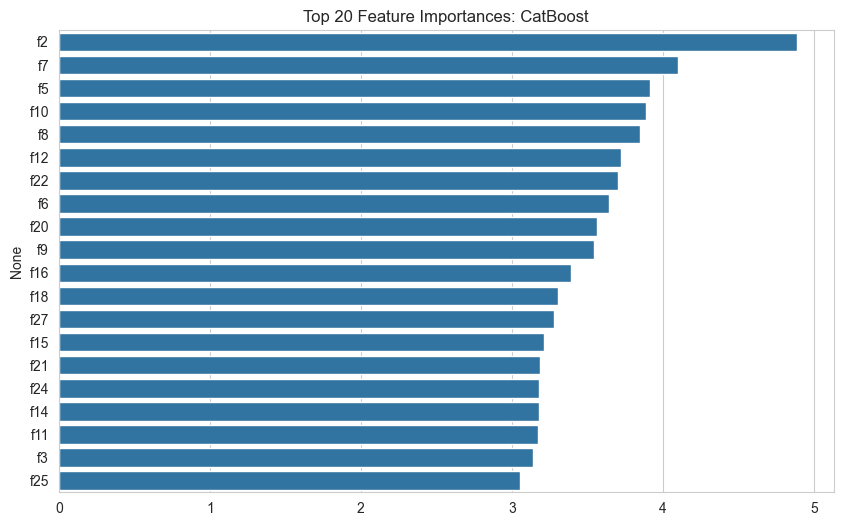

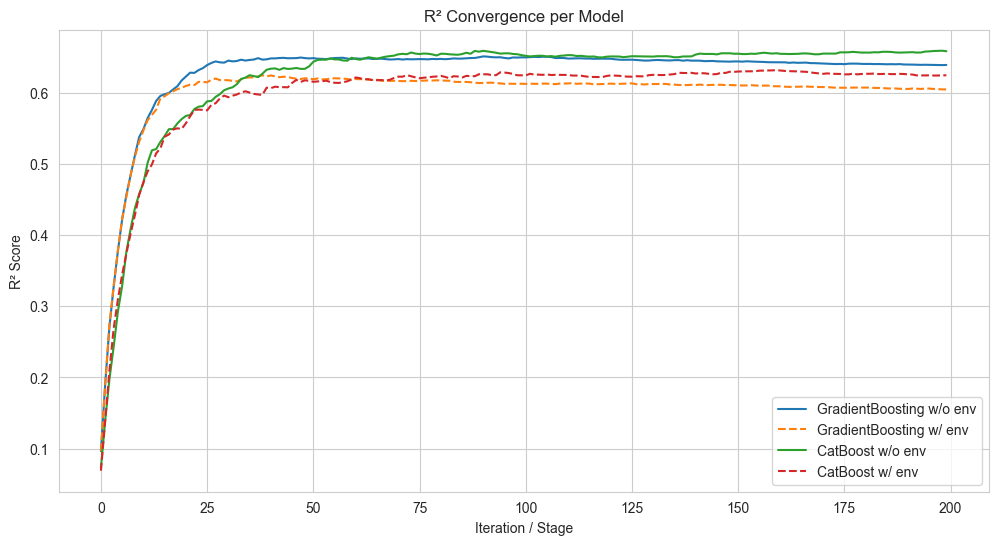

In [10]:
# ──────────────────────────────────────────────
# 6️⃣ Model Training, Monitoring & Feature Importance + R² Curves
# ──────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from collections import defaultdict

# Base features (temporal + smoothed dish history)
base_features = ["dow", "sin_hour", "cos_hour", "hour", "is_weekend"] + [c for c in df_features.columns if c.endswith("_smooth")]

# Env features
env_features = ["env_temp", "env_rhum", "env_precip", "env_wspd"]

# Target columns
target_cols = [c for c in df_features.columns if c.startswith("dish__")]

# Train/test split
X_base = df_features[base_features]
X_env = df_features[base_features + env_features]
y = df_features[target_cols]

Xb_train, Xb_valid, y_train, y_valid = train_test_split(X_base, y, test_size=0.2, random_state=RANDOM_STATE)
Xe_train, Xe_valid, _, _ = train_test_split(X_env, y, test_size=0.2, random_state=RANDOM_STATE)

# Define models
models = {
    "RandomForest": MultiOutputRegressor(RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE)),
    "GradientBoosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=RANDOM_STATE)),
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE, verbosity=0)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=RANDOM_STATE)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(iterations=200, depth=5, learning_rate=0.1, verbose=0, random_state=RANDOM_STATE)),
    "MLP": MultiOutputRegressor(
        make_pipeline(
            StandardScaler(),
            MLPRegressor(hidden_layer_sizes=(128,64), max_iter=500, random_state=RANDOM_STATE)
        )
    )
}

results = []
feature_importances = {}
r2_history = defaultdict(dict)  # store iterative R2 for plotting

for name, model in models.items():
    print(f"Training {name} ...")
    
    # Function to track R² per iteration (for iterative models)
    if name in ["GradientBoosting", "XGBoost", "LightGBM", "CatBoost", "MLP"]:
        # custom tracking for iterative models
        r2_per_iter_base = []
        r2_per_iter_env = []

        # Use partial_fit / staged_predict if available
        # For simplicity, we emulate R² tracking using staged_predict where supported
        # Otherwise fallback to final R²
        try:
            model.fit(Xb_train, y_train)
            if hasattr(model.estimators_[0], "staged_predict"):
                for y_pred in model.estimators_[0].staged_predict(Xb_valid):
                    r2_per_iter_base.append(r2_score(y_valid.iloc[:,0], y_pred))
            else:
                r2_per_iter_base = [r2_score(y_valid, model.predict(Xb_valid))]
        except:
            r2_per_iter_base = [r2_score(y_valid, model.predict(Xb_valid))]
        
        try:
            model.fit(Xe_train, y_train)
            if hasattr(model.estimators_[0], "staged_predict"):
                for y_pred in model.estimators_[0].staged_predict(Xe_valid):
                    r2_per_iter_env.append(r2_score(y_valid.iloc[:,0], y_pred))
            else:
                r2_per_iter_env = [r2_score(y_valid, model.predict(Xe_valid))]
        except:
            r2_per_iter_env = [r2_score(y_valid, model.predict(Xe_valid))]
        
        r2_history[name]['without_env'] = r2_per_iter_base
        r2_history[name]['with_env'] = r2_per_iter_env
    
    else:  # tree/static models
        # Train without env features
        model.fit(Xb_train, y_train)
        preds_base = model.predict(Xb_valid)
        r2_base = r2_score(y_valid, preds_base)
        
        # Train with env features
        model.fit(Xe_train, y_train)
        preds_env = model.predict(Xe_valid)
        r2_env = r2_score(y_valid, preds_env)
        
        r2_history[name]['without_env'] = [r2_base]
        r2_history[name]['with_env'] = [r2_env]
    
    # Store results for summary
    results.append({
        "Model": name,
        "R2_without_env": r2_history[name]['without_env'][-1],
        "R2_with_env": r2_history[name]['with_env'][-1]
    })
    
   # -------------------------
    # Safe Feature Importance Extraction
    # -------------------------
    try:
        if hasattr(model, "estimators_"):
            # Average across all outputs
            importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
        elif hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        else:
            importances = None

        if importances is not None:
            n_importances = len(importances)
            n_features = len(Xb_train.columns)

            # Adjust mismatch automatically
            if n_importances != n_features:
                print(f"⚠️  Feature length mismatch for {name}: {n_importances} vs {n_features}. Using generic feature names.")
                cols = [f"f{i}" for i in range(n_importances)]
            else:
                cols = Xb_train.columns

            feature_importances[name] = pd.Series(importances, index=cols)
        else:
            print(f"ℹ️  {name} has no feature_importances_ attribute.")

    except Exception as e:
        print(f"❌ Error computing feature importances for {name}: {e}")


    
    print(f"{name} done | R2 w/o env: {r2_history[name]['without_env'][-1]:.3f} | R2 w/ env: {r2_history[name]['with_env'][-1]:.3f}")

# -------------------------
# Summary table
# -------------------------
results_df = pd.DataFrame(results).sort_values("R2_with_env", ascending=False)
display(results_df)

# -------------------------
# Feature importance plot for top model
# -------------------------
best_model_name = results_df.iloc[0]['Model']
if best_model_name in feature_importances:
    fi = feature_importances[best_model_name].sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title(f"Top 20 Feature Importances: {best_model_name}")
    plt.show()

# -------------------------
# R² convergence plots
# -------------------------
plt.figure(figsize=(12,6))
for name, histories in r2_history.items():
    if len(histories['without_env']) > 1:
        plt.plot(histories['without_env'], label=f"{name} w/o env")
    if len(histories['with_env']) > 1:
        plt.plot(histories['with_env'], linestyle='--', label=f"{name} w/ env")

plt.xlabel("Iteration / Stage")
plt.ylabel("R² Score")
plt.title("R² Convergence per Model")
plt.legend()
plt.show()


Best model: CatBoost


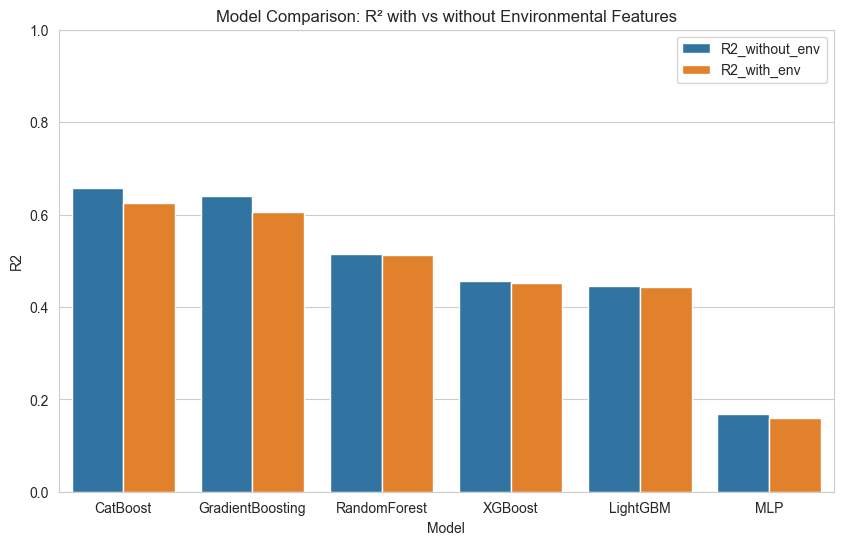

Residual analysis for CatBoost ...


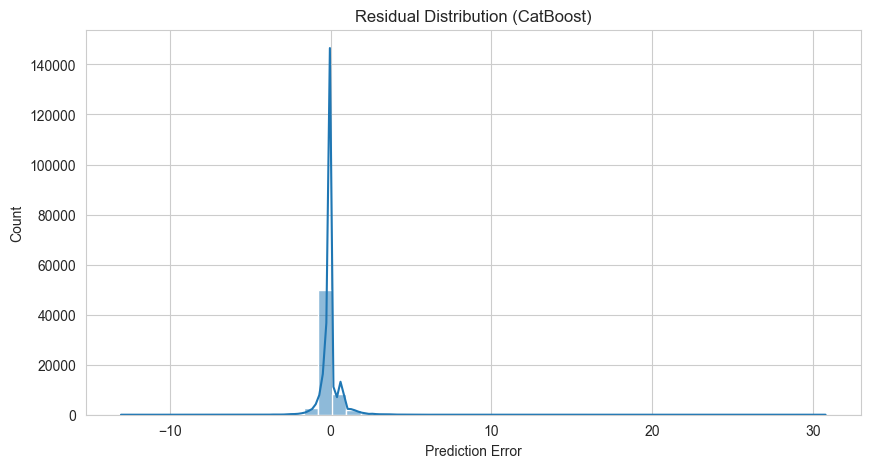

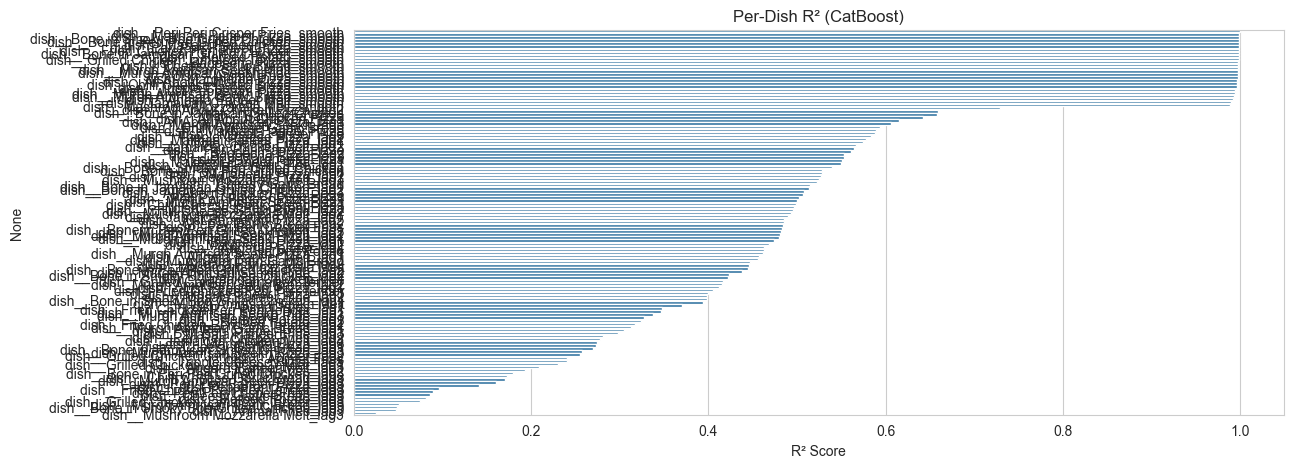

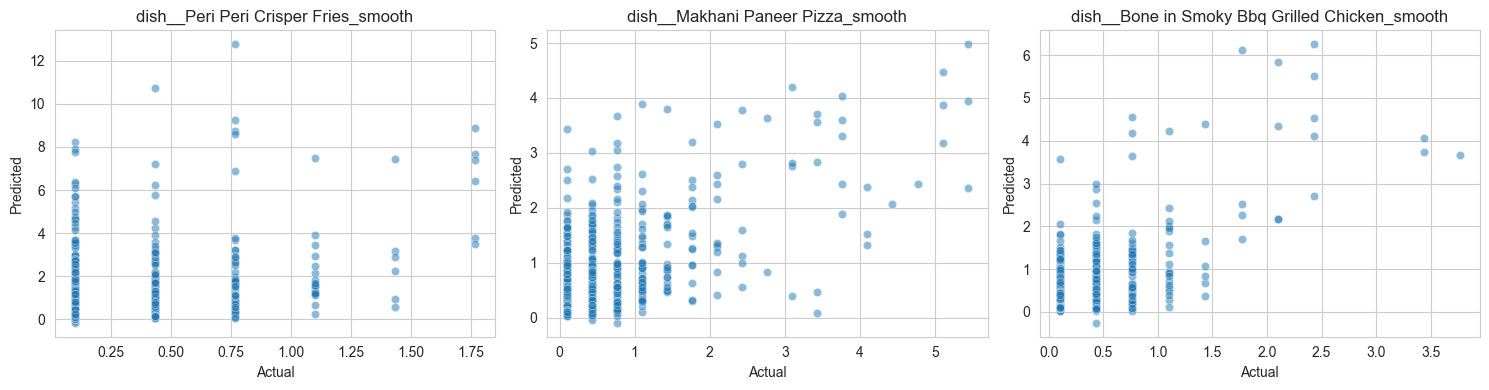

✅ Cell 7 complete — you now have model comparison and diagnostic plots.


In [ ]:
# ──────────────────────────────────────────────
# 7️⃣ Model Comparison & Residual Diagnostics
# ──────────────────────────────────────────────

best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Plot R² comparison for all models
plt.figure(figsize=(10,6))
sns.barplot(data=results_df.melt(id_vars="Model", 
                                 value_vars=["R2_without_env", "R2_with_env"],
                                 var_name="Setting", value_name="R2"),
            x="Model", y="R2", hue="Setting")
plt.title("Model Comparison: R² with vs without Environmental Features")
plt.ylim(0, 1)
plt.legend(title="")
plt.show()

# Residual analysis for best model
print(f"Residual analysis for {best_model_name} ...")

best_model = models[best_model_name]
best_model.fit(Xb_train, y_train)
y_pred = best_model.predict(Xb_valid)

# Flatten predictions for quick view
residuals = (y_valid - y_pred).values.flatten()

plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title(f"Residual Distribution ({best_model_name})")
plt.xlabel("Prediction Error")
plt.show()

# Per-dish R²
dish_r2 = {dish: r2_score(y_valid[dish], y_pred[:, i]) for i, dish in enumerate(y_valid.columns)}
dish_r2 = pd.Series(dish_r2).sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=dish_r2.values, y=dish_r2.index)
plt.title(f"Per-Dish R² ({best_model_name})")
plt.xlabel("R² Score")
plt.show()

# Predicted vs Actual Scatter for a few top dishes
top_dishes = dish_r2.head(3).index
plt.figure(figsize=(15,4))
for i, dish in enumerate(top_dishes):
    plt.subplot(1,3,i+1)
    sns.scatterplot(x=y_valid[dish], y=y_pred[:, i], alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{dish}")
plt.tight_layout()
plt.show()

print("✅ Cell 7 complete — you now have model comparison and diagnostic plots.")


In [5]:
from sklearn.metrics import r2_score

# =========================================================
# 📘 CSV REQUIREMENTS & DATA FORMAT
# =========================================================
"""
CSV FILE REQUIREMENTS
---------------------
Your CSV should look like:

order_placed_at,burger,pizza,coke
2025-10-25 10:05:00,2,4,1
2025-10-25 11:05:00,0,7,4
...

✅ REQUIRED:
- 'order_placed_at' : Timestamp of the order
- Columns for each dish with quantities (e.g., burger, pizza, coke)

⚙️ INTERNAL FEATURE ENGINEERING:
- hour : Extracted from 'order_placed_at'
- day_of_week : 0=Monday, 6=Sunday
- is_weekend : 1 if Saturday/Sunday
- lag features : Previous 1–3 hours per dish

🔢 DATA REQUIREMENT:
- Minimum: 200+ rows
- Recommended: 500–1000+ rows for stable results
"""

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import joblib

# =========================================================
# 🧠 FUNCTION 1: Train Multi-Dish Demand Model
# =========================================================
def train_demand_model(csv_path: str, save_path: str = "trained_model.pkl"):
    df = pd.read_csv(csv_path, parse_dates=['order_placed_at'])
    
    # Time features
    df['hour'] = df['order_placed_at'].dt.hour
    df['day_of_week'] = df['order_placed_at'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Identify dish columns
    dish_cols = [c for c in df.columns if c not in ['order_placed_at', 'hour', 'day_of_week', 'is_weekend']]
    
    # Sort by timestamp
    df = df.sort_values('order_placed_at').reset_index(drop=True)
    
    # Lag features: previous 1,2,3 hours per dish
    lag_hours = [1,2,3]
    for dish in dish_cols:
        for lag in lag_hours:
            df[f'{dish}_lag{lag}'] = df[dish].shift(lag).fillna(0)
    
    # Feature matrix
    feature_cols = ['hour', 'day_of_week', 'is_weekend'] + [c for c in df.columns if '_lag' in c]
    X = df[feature_cols]
    y = df[dish_cols]
    
    # Train/test split (last 20% for validation)
    split_idx = int(len(df)*0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train CatBoost MultiOutputRegressor
    model = MultiOutputRegressor(
        CatBoostRegressor(
            iterations=300,
            depth=5,
            learning_rate=0.1,
            verbose=0,
            random_state=42
        )
    )
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    r2_scores = {dish: r2_score(y_test[dish], y_pred[:,i]) for i, dish in enumerate(dish_cols)}
    print("✅ Model trained | Per-dish R² scores:", r2_scores)
    
    # Save model
    joblib.dump(model, save_path)
    print(f"💾 Model saved to {save_path}")
    
    return model, df, feature_cols, dish_cols

# =========================================================
# 🔮 FUNCTION 2: Predict Next Hour Demand
# =========================================================
def predict_next_hour(model, df, feature_cols, dish_cols):
    last_time = df['order_placed_at'].max()
    next_hour = last_time + pd.Timedelta(hours=1)
    
    # Build features
    hour = next_hour.hour
    day_of_week = next_hour.dayofweek
    is_weekend = int(day_of_week in [5,6])
    
    # Lag values: take last row's dish counts
    last_row = df.iloc[-1]
    feature_dict = {'hour': hour, 'day_of_week': day_of_week, 'is_weekend': is_weekend}
    for dish in dish_cols:
        feature_dict[f'{dish}_lag1'] = last_row[dish]
        feature_dict[f'{dish}_lag2'] = df[dish].iloc[-2] if len(df) > 1 else 0
        feature_dict[f'{dish}_lag3'] = df[dish].iloc[-3] if len(df) > 2 else 0
    
    X_next = pd.DataFrame([feature_dict])
    pred = model.predict(X_next)[0]
    
    result = dict(zip(dish_cols, pred))
    print(f"🕐 Predicted dishes for next hour ({next_hour}): {result}")
    return result

# =========================================================
# 🔮 FUNCTION 3: Predict Next 24 Hours
# =========================================================
def predict_next_24_hours(model, df, feature_cols, dish_cols):
    df_copy = df.copy().sort_values('order_placed_at').reset_index(drop=True)
    last_time = df_copy['order_placed_at'].max()
    
    predictions = []
    
    # Initialize rolling dish history for lag features
    rolling_history = {dish: df_copy[dish].tolist() for dish in dish_cols}
    
    for i in range(1, 25):  # next 24 hours
        next_hour = last_time + pd.Timedelta(hours=i)
        hour = next_hour.hour
        day_of_week = next_hour.dayofweek
        is_weekend = int(day_of_week in [5,6])
        
        # Build lag features
        feature_dict = {'hour': hour, 'day_of_week': day_of_week, 'is_weekend': is_weekend}
        for dish in dish_cols:
            # get last 3 hours for this dish (fill 0 if not enough history)
            feature_dict[f'{dish}_lag1'] = rolling_history[dish][-1] if len(rolling_history[dish]) >= 1 else 0
            feature_dict[f'{dish}_lag2'] = rolling_history[dish][-2] if len(rolling_history[dish]) >= 2 else 0
            feature_dict[f'{dish}_lag3'] = rolling_history[dish][-3] if len(rolling_history[dish]) >= 3 else 0
        
        X_next = pd.DataFrame([feature_dict])
        pred = model.predict(X_next)[0]
        
        # Append prediction
        predictions.append({'timestamp': next_hour, **dict(zip(dish_cols, pred))})
        
        # Update rolling history
        for j, dish in enumerate(dish_cols):
            rolling_history[dish].append(pred[j])
    
    pred_df = pd.DataFrame(predictions)
    print("🌤 Next 24-hour demand forecast generated.")
    return pred_df


In [6]:
csv_path = "dummy_orders.csv"

# Train the model
model, df, feature_cols, dish_cols = train_demand_model(csv_path, save_path="dummy_trained_model.pkl")


✅ Model trained | Per-dish R² scores: {'Burger': 0.1798848552872594, 'Pizza': 0.3546190740144398, 'Coke': 0.3722572344754116, 'Fries': 0.1451841918025435, 'Salad': -0.04739680896563092, 'Pasta': 0.028403944189478336, 'IceCream': -0.014614674262654725, 'Sushi': -0.13678419213722548, 'Sandwich': 0.028842711547356625, 'Soup': -0.06310956172143256}
💾 Model saved to dummy_trained_model.pkl


In [7]:
# Predict for the next hour
next_hour_prediction = predict_next_hour(model, df, feature_cols, dish_cols)
print(next_hour_prediction)


🕐 Predicted dishes for next hour (2025-10-28 19:00:00): {'Burger': np.float64(4.7498175074782605), 'Pizza': np.float64(6.094904226457867), 'Coke': np.float64(7.795372634080815), 'Fries': np.float64(4.252745750701939), 'Salad': np.float64(2.3721853970847837), 'Pasta': np.float64(3.6315038839462446), 'IceCream': np.float64(2.7466737989222842), 'Sushi': np.float64(1.636274583531858), 'Sandwich': np.float64(3.6065294999605166), 'Soup': np.float64(1.827564471226537)}
{'Burger': np.float64(4.7498175074782605), 'Pizza': np.float64(6.094904226457867), 'Coke': np.float64(7.795372634080815), 'Fries': np.float64(4.252745750701939), 'Salad': np.float64(2.3721853970847837), 'Pasta': np.float64(3.6315038839462446), 'IceCream': np.float64(2.7466737989222842), 'Sushi': np.float64(1.636274583531858), 'Sandwich': np.float64(3.6065294999605166), 'Soup': np.float64(1.827564471226537)}


In [8]:
# Predict for the next 24 hours
next_24h_prediction = predict_next_24_hours(model, df, feature_cols, dish_cols)
print(next_24h_prediction.head())

🌤 Next 24-hour demand forecast generated.
            timestamp    Burger     Pizza      Coke     Fries     Salad  \
0 2025-10-28 19:00:00  4.749818  6.094904  7.795373  4.252746  2.372185   
1 2025-10-28 20:00:00  4.985501  5.580658  8.813062  4.703483  2.275929   
2 2025-10-28 21:00:00  3.900517  5.463908  7.309938  4.151688  2.437659   
3 2025-10-28 22:00:00  2.920330  3.825064  5.758814  3.222169  2.441693   
4 2025-10-28 23:00:00  1.923297  2.262871  4.065642  2.042442  1.457093   

      Pasta  IceCream     Sushi  Sandwich      Soup  
0  3.631504  2.746674  1.636275  3.606529  1.827564  
1  3.203230  2.279723  1.721893  2.749667  1.726209  
2  3.583727  1.424423  1.683442  3.722825  1.540237  
3  2.705947  1.231486  1.344581  2.871973  0.906433  
4  0.947504  0.952111  1.856540  1.355214  0.652209  
